# Fashion MNIST Dataset
#### **Implementing a Tiny GoogLeNet and training it on fashion images**

Dataset Source: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [1]:
# Import Require Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-05-03 15:33:53.269914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# GPU Configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config) 

2023-05-03 15:33:55.516031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 15:33:55.517090: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-03 15:33:55.518294: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-03 15:33:55.526227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 15:33:55.526473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [4]:
# Extract .zip file of the dataset
from zipfile import ZipFile

datasetZipPath = './dataset/FashionMNIST.zip'
datasetExtractPath = './dataset/'

with ZipFile(datasetZipPath, 'r') as zipObj:
    zipObj.extractall(path=datasetExtractPath)

In [5]:
# Load Data
trainDataPath = './dataset/fashion-mnist_train.csv'
validDataPath = './dataset/fashion-mnist_test.csv'

trainData = pd.read_csv(trainDataPath)
validData = pd.read_csv(validDataPath)

In [6]:
# One-Hot Encoding Labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train = trainData['label'].values.reshape(-1, 1)
y_train = encoder.fit_transform(y_train).toarray()
y_valid = validData['label'].values.reshape(-1, 1)
y_valid = encoder.transform(y_valid).toarray()

In [7]:
# Reshapting X_train, and X_test
X_train = trainData.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 255
X_valid = validData.drop('label', axis=1).values.reshape(-1, 28, 28, 1) / 225

In [9]:
# Importing Required Packages, Libraries, and Functions
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Lambda 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.nn import local_response_normalization

In [10]:
# Creating Inception Module Class
class InceptionModude(keras.layers.Layer):
    def __init__(self, filters, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.normalization = Lambda(local_response_normalization)
        self.activation = keras.activations.get(activation)
        self.strands = []
        self.strands.append([
            Conv2D(filters, (1, 1), padding='same'), 
            self.normalization, 
            self.activation
        ])
        self.strands.append([
            Conv2D(filters, (1, 1), padding='same'),
            self.normalization,
            self.activation,
            Conv2D(filters, (3, 3), padding='same'),
            self.normalization,
            self.activation
        ])
        self.strands.append([
            Conv2D(filters, (1, 1), padding='same'),
            self.normalization,
            self.activation,
            Conv2D(filters, (5, 5), padding='same'),
            self.normalization,
            self.activation
        ])
        self.strands.append([
            MaxPooling2D((3, 3), padding='same'),
            Conv2D(filters, (1, 1), padding='same'),
            self.normalization,
            self.activation
        ])
    
    def call(self, inputs):
        output1, output2, output3, output4 = [inputs] * 4
        outputs = [output1, output2, output3, output4]
        for output, strand in zip(outputs, self.strands):
            for layer in strand:
                output = layer(output)
        return concatenate([output1, output2, output3, output4], axis=-1)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [11]:
def inceptionModule(prevLayer, 
                    filters_1by1, 
                    filters_3by3_reduced, 
                    filters_3by3, 
                    filters_5by5_reduced, 
                    filters_5by5, 
                    filters_pool_proj):
    # conv_1by1 = Conv2D(filters_1by1, (1, 1), padding='same', activation='relu')(prevLayer)
    
    conv_3by3 = Conv2D(filters_3by3_reduced, (1, 1), padding='same', activation='relu')(prevLayer)
    conv_3by3 = Conv2D(filters_3by3, (3, 3), padding='same', activation='relu')(conv_3by3)
    
    conv_5by5 = Conv2D(filters_5by5_reduced, (1, 1), padding='same', activation='relu')(prevLayer)
    conv_5by5 = Conv2D(filters_5by5, (5, 5), padding='same', activation='relu')(conv_5by5)
    
    # pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(prevLayer)
    # pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    
    # output = concatenate([conv_1by1, conv_3by3, conv_5by5, pool_proj], axis=-1)
    output = concatenate([conv_3by3, conv_5by5], axis=-1)
    return output

In [16]:
# Creating Model
inputs = Input(shape=(28, 28, 1))

X = Conv2D(16, (3, 3), padding='same')(inputs)
X = Lambda(local_response_normalization)(X)
X = Activation('relu')(X)

X = Dropout(rate=0.25)(X)
X = inceptionModule(X, 16, 16, 16, 16, 16, 16)
X = Lambda(local_response_normalization)(X)

X = MaxPooling2D(strides=(2, 2), padding='same')(X)

X = Dropout(rate=0.25)(X)
X = inceptionModule(X, 32, 32, 32, 32, 32, 32)
X = Lambda(local_response_normalization)(X)

X = MaxPooling2D(strides=(2, 2), padding='same')(X)

X = Dropout(rate=0.25)(X)
X = inceptionModule(X, 64, 64, 64, 64, 64, 64)
X = Lambda(local_response_normalization)(X)

X = MaxPooling2D(strides=(2, 2), padding='same')(X)

X = Dropout(rate=0.25)(X)
X = inceptionModule(X, 128, 128, 128, 128, 128, 128)
X = Lambda(local_response_normalization)(X)

X = MaxPooling2D(strides=(2, 2), padding='same')(X)

X = Flatten()(X)

X = Dense(250, activation='relu')(X)
X = BatchNormalization()(X)
X = Dropout(rate=0.35)(X)

outputs = Dense(10, activation='relu')(X)

model = Model(inputs=inputs, outputs=outputs)

# Compiling the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Model Info.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           lambda[0][0]                     
______________________________________________________________________________________________

In [18]:
# Setting Checkpoints
checkpoint = ModelCheckpoint('./trained_model/model_inception.h5', save_best_only=True)
earlyStopping = EarlyStopping(patience=14, restore_best_weights=True)

# Training
history = model.fit(X_train, y_train, epochs=50, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[checkpoint, earlyStopping])

Epoch 1/50
   7/1875 [..............................] - ETA: 33s - loss: nan - accuracy: 0.7768 

2023-05-03 15:57:37.316160: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 31s 17ms/step - loss: nan - accuracy: 0.8181 - val_loss: 0.6394 - val_accuracy: 0.8489
Epoch 2/50
1875/1875 [==============================] - 32s 17ms/step - loss: nan - accuracy: 0.8259 - val_loss: nan - val_accuracy: 0.8247
Epoch 3/50
1875/1875 [==============================] - 31s 17ms/step - loss: nan - accuracy: 0.8145 - val_loss: nan - val_accuracy: 0.8677
Epoch 4/50
1875/1875 [==============================] - 31s 17ms/step - loss: nan - accuracy: 0.8146 - val_loss: nan - val_accuracy: 0.8799
Epoch 5/50
1875/1875 [==============================] - 31s 17ms/step - loss: nan - accuracy: 0.8170 - val_loss: nan - val_accuracy: 0.8761
Epoch 6/50
1875/1875 [==============================] - 32s 17ms/step - loss: nan - accuracy: 0.8013 - val_loss: nan - val_accuracy: 0.8712
Epoch 7/50
1875/1875 [==============================] - 32s 17ms/step - loss: nan - accuracy: 0.8281 - val_loss: nan - val_accuracy: 0.8852
Epoch 8/50
1875/1875 [======

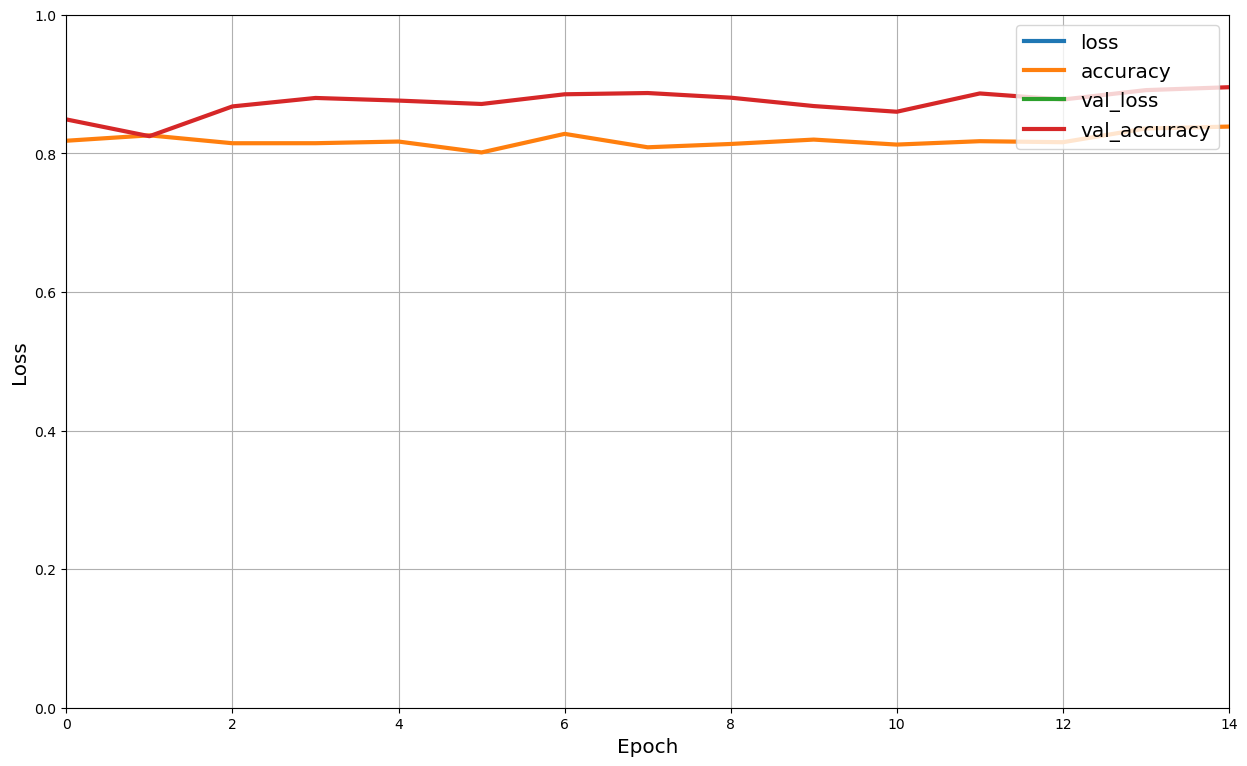

In [19]:
# Plotting Learning Curves
def plot_learning_curves(history, figsize=(15, 9)):
    plt.figure(figsize=figsize)
    history_pd = pd.DataFrame(history.history)
    plt.plot(history_pd, label=['loss', 'accuracy', 'val_loss', 'val_accuracy'], linewidth=3)
    plt.gca().set_ylim(0, 1)
    plt.gca().set_xlim(0, len(history_pd) - 1)
    plt.xlabel('Epoch', fontsize='x-large')
    plt.ylabel('Loss', fontsize='x-large')
    plt.legend(fontsize='x-large', loc=1)
    plt.savefig('./learning_curves.png')
    plt.grid(True)
    plt.show()

plot_learning_curves(history)